<a href="https://colab.research.google.com/github/JipFlinterman/TuringMachineJip/blob/main/ProjectTMDL_Version_2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict house prices

We decided to get a new dataset instead of the Titanic prediction set since it was a bit too easy. Right now we are going to predict the houseprices of houses!

Loading the data

In [ ]:
#LOADING LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter

from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

#LOADING TRAINING DF
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

Basic info on the df: We were checking the data for missing values and we did some checking in excel.

In [ ]:
#BASIC INFO ON THE DATA
print(df_train.describe())
print(df_train.columns)

# Initialising a list of columns
columns = list(df_train.columns)
columns_test = list(df_test.columns)

#Making list of outliers
outlier_id = []

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

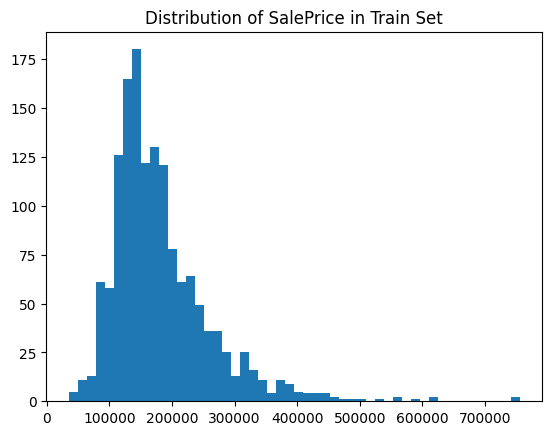

Max SalePrice: 755000
Min SalePrice: 34900


In [ ]:
# Checking the distribution of Sale Price (verifying right-skew)
plt.hist(df_train["SalePrice"], bins=50)
plt.title("Distribution of SalePrice in Train Set")
plt.show()

print("Max SalePrice:", max(df_train["SalePrice"]))
print("Min SalePrice:", min(df_train["SalePrice"]))

In [ ]:
# Verifying the existence of all columns in test and train data
for x in columns:
  print(df_train[x].count(), x)

for y in columns_test:
  print(df_test[y].count(), y)

1460 Id
1460 MSSubClass
1460 MSZoning
1201 LotFrontage
1460 LotArea
1460 Street
91 Alley
1460 LotShape
1460 LandContour
1460 Utilities
1460 LotConfig
1460 LandSlope
1460 Neighborhood
1460 Condition1
1460 Condition2
1460 BldgType
1460 HouseStyle
1460 OverallQual
1460 OverallCond
1460 YearBuilt
1460 YearRemodAdd
1460 RoofStyle
1460 RoofMatl
1460 Exterior1st
1460 Exterior2nd
588 MasVnrType
1452 MasVnrArea
1460 ExterQual
1460 ExterCond
1460 Foundation
1423 BsmtQual
1423 BsmtCond
1422 BsmtExposure
1423 BsmtFinType1
1460 BsmtFinSF1
1422 BsmtFinType2
1460 BsmtFinSF2
1460 BsmtUnfSF
1460 TotalBsmtSF
1460 Heating
1460 HeatingQC
1460 CentralAir
1459 Electrical
1460 1stFlrSF
1460 2ndFlrSF
1460 LowQualFinSF
1460 GrLivArea
1460 BsmtFullBath
1460 BsmtHalfBath
1460 FullBath
1460 HalfBath
1460 BedroomAbvGr
1460 KitchenAbvGr
1460 KitchenQual
1460 TotRmsAbvGrd
1460 Functional
1460 Fireplaces
770 FireplaceQu
1379 GarageType
1379 GarageYrBlt
1379 GarageFinish
1460 GarageCars
1460 GarageArea
1379 GarageQual

We decided to drop a lot of data. We had like 1460 observations and decided to drop entire columns which had less than 1400 observation. This was our cutoff point.
All columns which had more than 1400 observations but less than 1460 we dropped the rows with missing values. This left us with 69 columns instead of 81 and 1412 observations instead of 1460.

In [ ]:
#Initialising filtered dataframes
df_train_filtered = df_train
df_test_filtered = df_test

In [ ]:
# Seperating categorical and numerical columns
cat_cols = df_train.select_dtypes(include=["object"]).columns
num_cols = df_train.select_dtypes(include=np.number).drop(["SalePrice", "Id"], axis=1).columns

# Imputers to be fit onto training data
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="mean")

# Impute training
df_train_filtered[cat_cols] = cat_imputer.fit_transform(df_train[cat_cols])
df_train_filtered[num_cols] = num_imputer.fit_transform(df_train[num_cols])

# Imputing test using the same fit
df_test_filtered[cat_cols] = cat_imputer.transform(df_test[cat_cols])
df_test_filtered[num_cols] = num_imputer.transform(df_test[num_cols])

In [ ]:
# Log-transforming skewed numbers
skewed_cols = df_train_filtered[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols_final = skewed_cols[abs(skewed_cols) > 1].index

for skew in skewed_cols_final:
  df_train_filtered[skew] = np.log1p(df_train_filtered[skew])
  df_test_filtered[skew] = np.log1p(df_test_filtered[skew])

In [ ]:
# Attempting Exploratory feature analysis
threshold_95 = df_train_filtered["SalePrice"].quantile(0.95)
threshold_98 = df_train_filtered["SalePrice"].quantile(0.98)

print(f"95th percentile: {threshold_95}")
print(f"98th percentile: {threshold_98}")

# Homes above 95th or 98th percentile
df_luxury_95 = df_train_filtered[df_train_filtered["SalePrice"] >= threshold_95]
df_luxury_98 = df_train_filtered[df_train_filtered["SalePrice"] >= threshold_98]

features_to_check = ["GrLivArea", "OverallQual", "GarageCars", "TotalBsmtSF"]
for feature in features_to_check:
    avg_all = df_train_filtered[feature].mean()
    avg_luxury = df_luxury_95[feature].mean()
    print(f"{feature} → Avg (All): {avg_all:.2f}, Avg (95+): {avg_luxury:.2f}")

95th percentile: 326099.9999999999
98th percentile: 394931.06
GrLivArea → Avg (All): 7.27, Avg (95+): 7.77
OverallQual → Avg (All): 6.10, Avg (95+): 8.66
GarageCars → Avg (All): 1.77, Avg (95+): 2.85
TotalBsmtSF → Avg (All): 6.75, Avg (95+): 7.43


In [ ]:
# Add luxury indicator using SalePrice (training only)
df_train_filtered["is_luxury"] = (df_train_filtered["SalePrice"] >= 394931).astype(int)

# For test set, we must use *features*, not SalePrice (since it's unknown),
# We use 95th percentile because we are checking for outliers as a combination of 3 features
df_test_filtered["is_luxury"] = (
    (df_test_filtered["GrLivArea"] >= 7.77) &
    (df_test_filtered["OverallQual"] >= 8.66) &
    (df_test_filtered["GarageCars"] >= 3)
).astype(int)

In [ ]:
# Checking the number of 'luxury' houses in training and test data
print(df_train_filtered["is_luxury"].sum())
print(df_test_filtered["is_luxury"].sum())

30
25


In [ ]:
# Encoding
# Combining test and train data
df_train_filtered['is_train'] = 1
df_test_filtered['is_train'] = 0
df_test_filtered['SalePrice'] = np.nan

combined_data = pd.concat([df_train_filtered, df_test_filtered], axis=0)
combined_data_encoded = pd.get_dummies(combined_data) # Encoding step

# Splitting back into train and test data
df_train_filtered = combined_data_encoded[combined_data_encoded['is_train'] == 1].drop('is_train', axis=1)
df_test_filtered = combined_data_encoded[combined_data_encoded['is_train'] == 0].drop(['is_train','SalePrice'], axis=1)

In [ ]:
# Defining y and X
y = df_train_filtered["SalePrice"]
X = df_train_filtered.drop("SalePrice", axis=1)
X_test = df_test_filtered

def accuracy_within_10_percent(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    relative_error = np.abs(y_true - y_pred) / y_true

    within_10_percent = (relative_error <= 0.10)

    accuracy = np.mean(within_10_percent)

    return accuracy

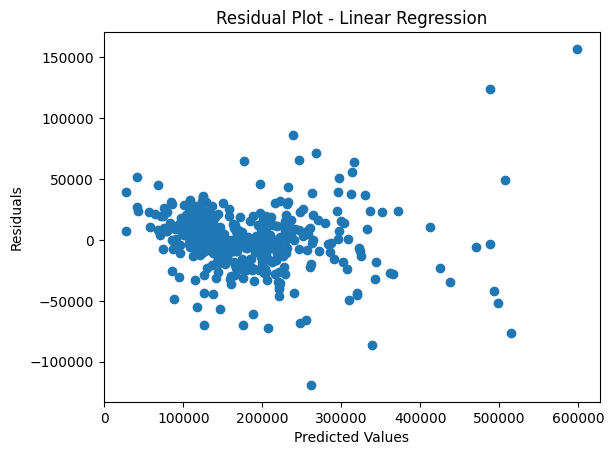

Outliers from Linear Regression training model: 12
----
MSE:  612541408.6164156
----
RMSE (all houses):  24749.57390777497
RMSE for non-luxury homes:  22376.337513977727
----
R2:  0.912219378299961
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 598289.012812481
----
Training score:  0.9440470896531861
Testing score:  0.912219378299961
----
Test Accuracy within 10%: 64.38%
Test Accuracy within 10% (non-luxury): 64.32%
----
Top Positive & Negative Coefficients:
RoofMatl_ClyTile       -338920.085584
Condition2_PosN        -118442.902749
is_luxury                95817.116120
RoofMatl_WdShngl         91244.471536
RoofMatl_WdShake         67228.579189
GarageQual_Ex            60231.843109
RoofMatl_CompShg         59936.911670
GarageCond_Ex           -57327.512725
RoofMatl_Roll            48230.990939
RoofMatl_Tar&Grv         44737.520098
1stFlrSF                 42978.373953
Neighborhood_StoneBr     41954.976329
PoolQC_Ex                41552.348790
Condition2_Artery        412

In [ ]:
# Splitting data into test and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=42)

# Linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
res_lr = y_val - y_pred

# Calculating accuracy
accuracy_10pct_lr = accuracy_within_10_percent(y_val, y_pred)

# Residual plot (Visual test for non-linearity)
plt.scatter(y_pred, res_lr)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Linear Regression')
plt.show()

# Predict on training set
y_pred_train = lr.predict(X_train)
res_train = y_train - y_pred_train
res_train = pd.Series(res_train, index=y_train.index)

# Trying to find outliers here instead, we need it with relation to sale price
# not just on its own
threshold = 3 * np.std(res_train)
LR_train_outliers = X_train[np.abs(res_train) > threshold]
print(f"Outliers from Linear Regression training model: {len(LR_train_outliers)}")

# Calculating mse and r2
mse_lr = mean_squared_error(y_val, y_pred)
r2_lr = r2_score(y_val, y_pred)

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_lr = y_val[non_luxury_mask]
y_pred_nonlux_lr = y_pred[non_luxury_mask]
mse_nonlux_lr = mean_squared_error(y_val_nonlux_lr, y_pred_nonlux_lr)
accuracy_10pct_lr_nonlux = accuracy_within_10_percent(y_val_nonlux_lr, y_pred_nonlux_lr)

print("----")
print("MSE: ", mse_lr)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_lr))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_lr))
print("----")
print("R2: ", r2_lr) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", lr.score(X_train, y_train))
print("Testing score: ", lr.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_lr:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_lr_nonlux:.2%}")

# Storing the coefficients as a pandas series
coef_series = pd.Series(lr.coef_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

# Ridge regression

10


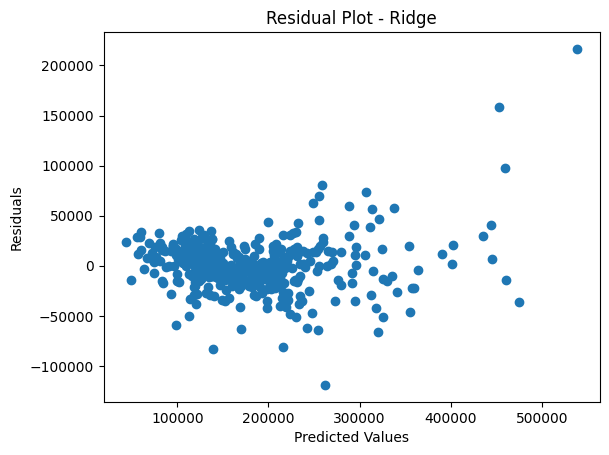

----
MSE:  688754530.6923349
----
RMSE (all houses):  26244.133262356652
RMSE for non-luxury homes:  22324.1210358958
----
R2:  0.9012976101657277
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 538522.1935606163
----
Training score:  0.9187481942559649
Testing score:  0.9012976101657277
----
Test Accuracy within 10%: 61.87%
Test Accuracy within 10% (non-luxury): 61.74%
----
Top Positive & Negative Coefficients:
is_luxury               64963.748421
Neighborhood_StoneBr    24170.788619
Neighborhood_NoRidge    23613.307320
1stFlrSF                22498.238364
RoofMatl_ClyTile       -21206.930393
BsmtQual_Ex             18439.978608
PoolQC_Ex               16456.774191
Condition2_PosN        -15539.899676
KitchenQual_Ex          15003.106199
Exterior1st_BrkFace     14983.383429
PoolQC_Gd              -14951.891825
Neighborhood_Edwards   -14369.451540
Exterior2nd_ImStucc     13696.105530
RoofMatl_WdShngl        13499.745780
Neighborhood_Mitchel   -13458.649582
LandContour_Bnk 

In [ ]:
# Ridge regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Determinig the best alpha, which is then used for the regression
best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

# Fitting the data on the ridge model
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)
y_pred = ridge_best.predict(X_val)
res_ridge = y_val - y_pred

# Calculating MSE, r2 and accuracy
mse_ridge = mean_squared_error(y_val, y_pred)
r2_ridge = r2_score(y_val, y_pred)
accuracy_10pct_ridge = accuracy_within_10_percent(y_val, y_pred)

# residual plot
plt.scatter(y_pred, res_ridge)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Ridge')
plt.show()

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_ridge = y_val[non_luxury_mask]
y_pred_nonlux_ridge = y_pred[non_luxury_mask]
mse_nonlux_ridge = mean_squared_error(y_val_nonlux_ridge, y_pred_nonlux_ridge)
accuracy_10pct_ridge_nonlux = accuracy_within_10_percent(y_val_nonlux_ridge, y_pred_nonlux_ridge)

print("----")
print("MSE: ", mse_ridge)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_ridge))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_ridge))
print("----")
print("R2: ", r2_ridge) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", ridge_best.score(X_train, y_train))
print("Testing score: ", ridge_best.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_ridge:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_ridge_nonlux:.2%}")

coef_series = pd.Series(ridge_best.coef_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

# Lasso Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.615e+10, tolerance: 4.742e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.016e+10, tolerance: 4.840e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.823e+10, tolerance: 4.842e

100
Outliers from Lasso training model: 13
Outliers from Lasso validation model: 7


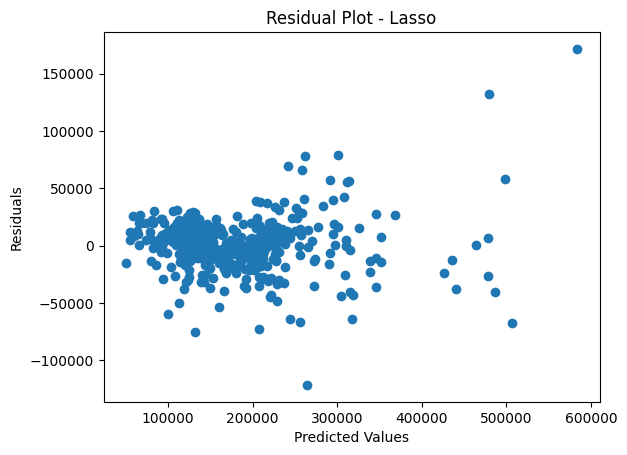

----
MSE:  581027050.5488529
----
RMSE (all houses):  24104.50270279088
RMSE for non-luxury homes:  21360.17842972138
----
R2:  0.9167355626831472
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 583429.3800135243
----
Training score:  0.9286594017303137
Testing score:  0.9167355626831472
----
Test Accuracy within 10%: 65.07%
Test Accuracy within 10% (non-luxury): 65.02%
----
Top Positive & Negative Coefficients:
RoofMatl_ClyTile       -208939.108831
is_luxury               105492.159956
Condition2_PosN         -51415.890738
1stFlrSF                 42862.514195
Neighborhood_StoneBr     35432.699764
Neighborhood_NoRidge     28805.396373
BsmtQual_Ex              27989.316132
Exterior1st_BrkFace      21846.309316
KitchenQual_Ex           20673.625493
Neighborhood_Crawfor     14647.276332
PoolQC_Ex                14543.367007
RoofMatl_WdShngl         14460.615060
BsmtExposure_Gd          14096.495284
Functional_Typ           12337.923303
LotArea                  11473.472175
N

In [ ]:
# Lasso Regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Determining best alpha
best_alpha = grid_search.best_estimator_.alpha
print(best_alpha)

# Fitting the data on the Lasso model
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(X_train, y_train)
y_pred = lasso_best.predict(X_val)
res_lasso = y_val - y_pred

# Calculating mse, r2 and accuracy
mse_lasso = mean_squared_error(y_val, y_pred)
r2_lasso = r2_score(y_val, y_pred)
accuracy_10pct_lasso = accuracy_within_10_percent(y_val, y_pred)

# Predict on training data
y_pred_train = lasso_best.predict(X_train)
res_train = y_train - y_pred_train
residuals_train = pd.Series(res_train, index=y_train.index)

# Flag training outliers
threshold = 3 * np.std(residuals_train)
train_outliers = X_train[np.abs(residuals_train) > threshold]
print(f"Outliers from Lasso training model: {len(train_outliers)}")

# Flag outliers
threshold = 3 * np.std(res_lasso)
outliers = X_val[np.abs(res_lasso) > threshold]
print(f"Outliers from Lasso validation model: {len(outliers)}")

# Residual plot
plt.scatter(y_pred, res_lasso)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Lasso')
plt.show()

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_lasso = y_val[non_luxury_mask]
y_pred_nonlux_lasso = y_pred[non_luxury_mask]
mse_nonlux_lasso = mean_squared_error(y_val_nonlux_lasso, y_pred_nonlux_lasso)
accuracy_10pct_lasso_nonlux = accuracy_within_10_percent(y_val_nonlux_lasso, y_pred_nonlux_lasso)

print("----")
print("MSE: ", mse_lasso)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_lasso))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_lasso))
print("----")
print("R2: ", r2_lasso) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", lasso_best.score(X_train, y_train))
print("Testing score: ", lasso_best.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_lasso:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_lasso_nonlux:.2%}")

coef_series = pd.Series(lasso_best.coef_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

Outliers from ElasticNet training model: 12
Outliers from ElasticNet validation model: 8


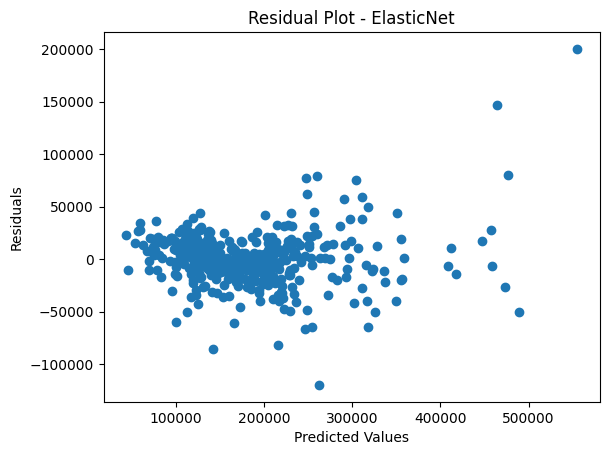

----
MSE:  657478857.3918077
----
RMSE (all houses):  25641.350537594695
RMSE for non-luxury homes:  22370.803560321692
----
R2:  0.9057795896821963
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 554756.6803124272
----
Training score:  0.9268214484025585
Testing score:  0.9057795896821963
----
Test Accuracy within 10%: 61.87%
Test Accuracy within 10% (non-luxury): 61.97%
----
Top Positive & Negative Coefficients:
is_luxury               80182.597911
RoofMatl_ClyTile       -35874.765931
Neighborhood_StoneBr    30133.789851
PoolQC_Ex               25997.369785
Neighborhood_NoRidge    25601.558424
1stFlrSF                25354.862823
Condition2_PosN        -24478.083494
PoolQC_Gd              -23634.346318
RoofMatl_WdShngl        21184.595952
BsmtQual_Ex             18998.140654
Exterior2nd_ImStucc     17818.345598
Exterior1st_BrkFace     16566.585263
Neighborhood_Edwards   -16530.533558
Neighborhood_Mitchel   -16101.787300
KitchenQual_Ex          15245.722633
LandContour_Bn

In [ ]:
#Elastic Net
elastic_net = ElasticNet(max_iter=10000)

# Defining parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1,0.3, 0.5, 0.7, 0.9]
}

# Performing grid search
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Getting best parameters
best_alpha = grid_search.best_params_['alpha']
best_l1 = grid_search.best_params_['l1_ratio']
best_elastic = grid_search.best_estimator_

# Fitting the data into the ElasticNet model
y_pred = best_elastic.predict(X_val)
res_elastic = y_val - y_pred

# Calculating mse, r2 and accuracy
mse_elastic = mean_squared_error(y_val, y_pred)
r2_elastic = r2_score(y_val, y_pred)
accuracy_10pct_elastic = accuracy_within_10_percent(y_val, y_pred)

# Predict on training data
y_pred_train = best_elastic.predict(X_train)
res_train = y_train - y_pred_train
residuals_train = pd.Series(res_train, index=y_train.index)

# Flag training outliers
threshold = 3 * np.std(residuals_train)
train_outliers = X_train[np.abs(residuals_train) > threshold]
print(f"Outliers from ElasticNet training model: {len(train_outliers)}")

# Flag outliers
threshold = 3 * np.std(res_elastic)
outliers = X_val[np.abs(res_elastic) > threshold]
print(f"Outliers from ElasticNet validation model: {len(outliers)}")

# Residual plot
plt.scatter(y_pred, res_elastic)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - ElasticNet')
plt.show()

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_elastic = y_val[non_luxury_mask]
y_pred_nonlux_elastic = y_pred[non_luxury_mask]
mse_nonlux_elastic = mean_squared_error(y_val_nonlux_elastic, y_pred_nonlux_elastic)
accuracy_10pct_elastic_nonlux = accuracy_within_10_percent(y_val_nonlux_elastic, y_pred_nonlux_elastic)

print("----")
print("MSE: ", mse_elastic)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_elastic))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_elastic))
print("----")
print("R2: ", r2_elastic) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", best_elastic.score(X_train, y_train))
print("Testing score: ", best_elastic.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_elastic:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_elastic_nonlux:.2%}")

coef_series = pd.Series(best_elastic.coef_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

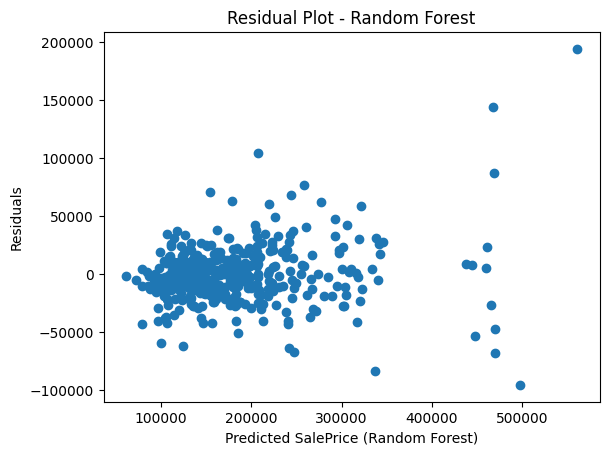

----
MSE:  627154852.9643184
----
RMSE (all houses):  25043.05997605561
RMSE for non-luxury homes:  21031.77631541876
----
R2:  0.9101251897079843
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 560939.89
----
Training score:  0.9808312799489036
Testing score:  0.9101251897079843
----
Test Accuracy within 10%: 66.89%
Test Accuracy within 10% (non-luxury): 67.61%
----
Top Positive & Negative Coefficients:
OverallQual         0.529933
is_luxury           0.109592
GrLivArea           0.102317
TotalBsmtSF         0.023725
LotArea             0.017136
BsmtFinSF1          0.016787
GarageArea          0.014442
GarageCars          0.013699
BsmtQual_Ex         0.013037
1stFlrSF            0.012471
GarageFinish_Unf    0.010066
YearBuilt           0.010011
LotFrontage         0.008791
2ndFlrSF            0.006972
YearRemodAdd        0.006533
Fireplaces          0.006124
BsmtUnfSF           0.004698
OpenPorchSF         0.004477
FullBath            0.004277
KitchenQual_Gd      0.004184

In [ ]:
# Random Forest regression
rf_regression = RandomForestRegressor()
rf_regression.fit(X_train,y_train)
y_pred = rf_regression.predict(X_val)
res_rf = y_val - y_pred

# Calculating mse, r2 and accuracy
mse_rf = mean_squared_error(y_val, y_pred)
r2_rf = r2_score(y_val, y_pred)
accuracy_10pct_rf = accuracy_within_10_percent(y_val, y_pred)

# Residual plot
plt.scatter(y_pred, res_rf)
plt.xlabel('Predicted SalePrice (Random Forest)')
plt.ylabel('Residuals')
plt.title('Residual Plot - Random Forest')
plt.show()

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_rf = y_val[non_luxury_mask]
y_pred_nonlux_rf = y_pred[non_luxury_mask]
mse_nonlux_rf = mean_squared_error(y_val_nonlux_rf, y_pred_nonlux_rf)
accuracy_10pct_rf_nonlux = accuracy_within_10_percent(y_val_nonlux_rf, y_pred_nonlux_rf)

print("----")
print("MSE: ", mse_rf)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_rf))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_rf))
print("----")
print("R2: ", r2_rf) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", rf_regression.score(X_train, y_train))
print("Testing score: ", rf_regression.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_rf:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_rf_nonlux:.2%}")

coef_series = pd.Series(rf_regression.feature_importances_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

# XGBoost

Outliers from XGBoost training model: 17
Outliers from XGBoost validation model: 6


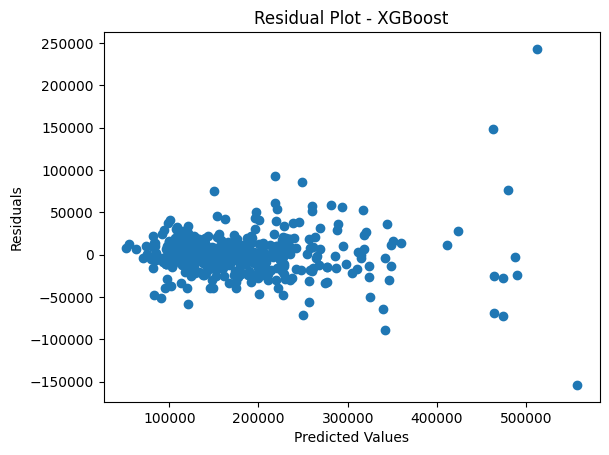

----
MSE:  708840796.1158155
----
RMSE (all houses):  26624.064229861968
RMSE for non-luxury homes:  20937.84275363138
----
R2:  0.8984191355977997
----
Max actual SalePrice: 755000.0
Max predicted SalePrice: 557005.6
----
Training score:  0.9997522148253891
Testing score:  0.8984191355977997
----
Test Accuracy within 10%: 67.81%
Test Accuracy within 10% (non-luxury): 68.31%
----
Top Positive & Negative Coefficients:
is_luxury            0.366773
OverallQual          0.163294
BsmtQual_Ex          0.074035
GarageFinish_Unf     0.063621
ExterQual_TA         0.025016
FireplaceQu_Ex       0.024897
GarageCars           0.022655
LandSlope_Sev        0.021405
GrLivArea            0.017670
GarageType_Detchd    0.016867
CentralAir_N         0.015653
BsmtQual_TA          0.011823
Alley_Grvl           0.010768
Functional_Typ       0.009670
KitchenQual_Gd       0.008190
KitchenQual_Ex       0.006235
Fireplaces           0.006120
TotalBsmtSF          0.004846
SaleType_WD          0.004517
PavedDriv

In [ ]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
res_xgb = y_val - y_pred
residuals = pd.Series(res_xgb, index=y_val.index)

# Predict on training data
y_pred_train = xgb.predict(X_train)
res_train = y_train - y_pred_train
residuals_train = pd.Series(res_train, index=y_train.index)

# Flag training outliers
threshold = 3 * np.std(residuals_train)
train_outliers = X_train[np.abs(residuals_train) > threshold]
print(f"Outliers from XGBoost training model: {len(train_outliers)}")

# Flag outliers
threshold = 3 * np.std(residuals)
outliers = X_val[np.abs(residuals) > threshold]
print(f"Outliers from XGBoost validation model: {len(outliers)}")

# Calculating mse, r2 and accuracy
mse_xgb = mean_squared_error(y_val, y_pred)
r2_xgb = r2_score(y_val, y_pred)
accuracy_10pct_xgb = accuracy_within_10_percent(y_val, y_pred)

# Residual plot
plt.scatter(y_pred, res_xgb)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - XGBoost')
plt.show()

# RMSE for non-luxury homes (is_luxury == 0)
non_luxury_mask = X_val["is_luxury"] == 0
y_val_nonlux_xgb = y_val[non_luxury_mask]
y_pred_nonlux_xgb = y_pred[non_luxury_mask]
mse_nonlux_xgb = mean_squared_error(y_val_nonlux_xgb, y_pred_nonlux_xgb)
accuracy_10pct_xgb_nonlux = accuracy_within_10_percent(y_val_nonlux_xgb, y_pred_nonlux_xgb)

print("----")
print("MSE: ", mse_xgb)
print("----")
print("RMSE (all houses): ", math.sqrt(mse_xgb))
print("RMSE for non-luxury homes: ", math.sqrt(mse_nonlux_xgb))
print("----")
print("R2: ", r2_xgb) # Added to check if it is the same as testing score
print("----")
print("Max actual SalePrice:", max(y_val))
print("Max predicted SalePrice:", max(y_pred))
print("----")
print("Training score: ", xgb.score(X_train, y_train))
print("Testing score: ", xgb.score(X_val, y_val))
print("----")
print(f"Test Accuracy within 10%: {accuracy_10pct_xgb:.2%}")
print(f"Test Accuracy within 10% (non-luxury): {accuracy_10pct_xgb_nonlux:.2%}")

coef_series = pd.Series(xgb.feature_importances_, index=X_train.columns)
coef_series_sorted = coef_series.sort_values(key=abs, ascending=False)

print("----")
print("Top Positive & Negative Coefficients:")
print(coef_series_sorted.head(20))

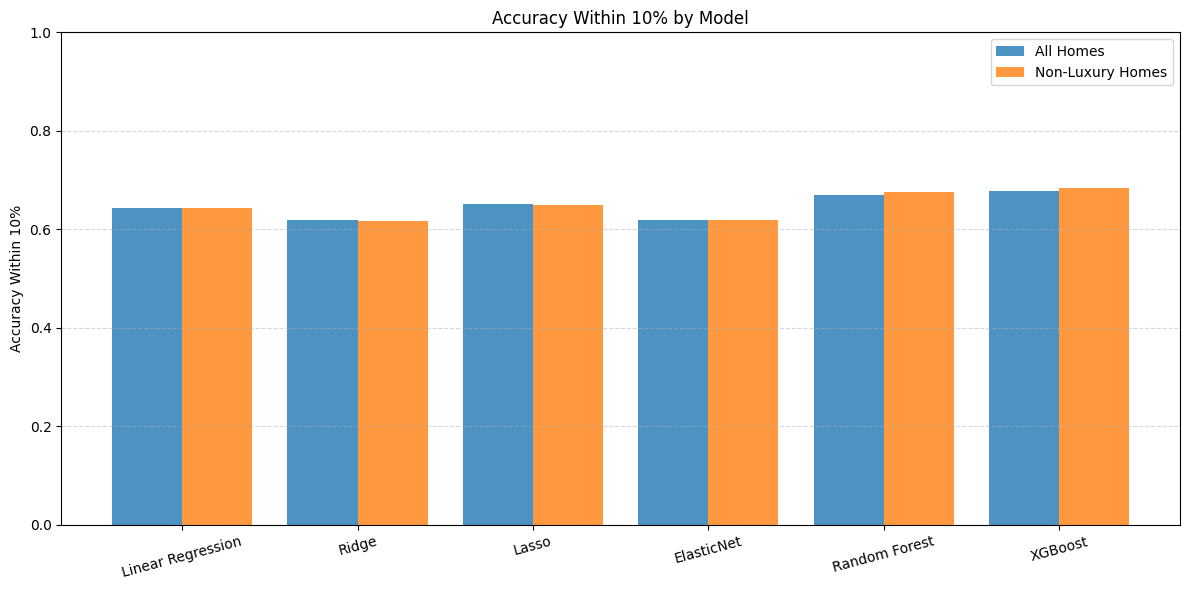

In [ ]:
# Plotting and comparing accuracies
# Names of the 6 models
model_names = [
    "Linear Regression",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "Random Forest",
    "XGBoost"
]

# Accuracies for all homes (within 10%)
accuracies_all = [
    accuracy_10pct_lr,
    accuracy_10pct_ridge,
    accuracy_10pct_lasso,
    accuracy_10pct_elastic,
    accuracy_10pct_rf,
    accuracy_10pct_xgb
]

# Accuracies for non-luxury homes
accuracies_nonlux = [
    accuracy_10pct_lr_nonlux,
    accuracy_10pct_ridge_nonlux,
    accuracy_10pct_lasso_nonlux,
    accuracy_10pct_elastic_nonlux,
    accuracy_10pct_rf_nonlux,
    accuracy_10pct_xgb_nonlux
]

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(model_names))

plt.bar(x, accuracies_all, width=bar_width, label="All Homes", alpha=0.8)
plt.bar([i + bar_width for i in x], accuracies_nonlux, width=bar_width, label="Non-Luxury Homes", alpha=0.8)

# Formatting
plt.xticks([i + bar_width / 2 for i in x], model_names, rotation=15)
plt.ylabel("Accuracy Within 10%")
plt.ylim(0, 1)
plt.title("Accuracy Within 10% by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


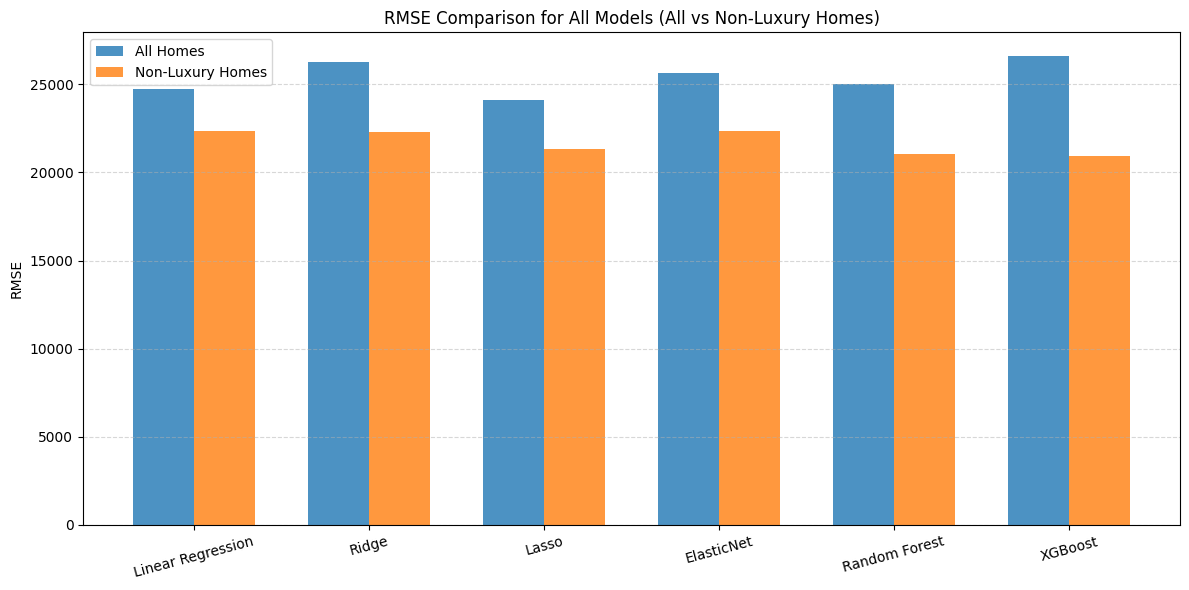

In [ ]:
# List of model names (in order)
model_names = [
    "Linear Regression",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "Random Forest",
    "XGBoost"
]

# Replace these with your actual RMSE values
rmse_all = [
    math.sqrt(mse_lr),
    math.sqrt(mse_ridge),
    math.sqrt(mse_lasso),
    math.sqrt(mse_elastic),
    math.sqrt(mse_rf),
    math.sqrt(mse_xgb)
]

rmse_nonlux = [
    math.sqrt(mse_nonlux_lr),
    math.sqrt(mse_nonlux_ridge),
    math.sqrt(mse_nonlux_lasso),
    math.sqrt(mse_nonlux_elastic),
    math.sqrt(mse_nonlux_rf),
    math.sqrt(mse_nonlux_xgb)
]

# Bar chart setup
x = np.arange(len(model_names))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, rmse_all, width=bar_width, label='All Homes', alpha=0.8)
plt.bar(x + bar_width, rmse_nonlux, width=bar_width, label='Non-Luxury Homes', alpha=0.8)

# Formatting
plt.xticks(x + bar_width / 2, model_names, rotation=15)
plt.ylabel("RMSE")
plt.title("RMSE Comparison for All Models (All vs Non-Luxury Homes)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
